In [25]:
import pandas as pd
import yfinance as yf
import time
from datetime import datetime, timedelta, date
import math
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
from scipy.stats import norm
import plotly.io as pio

In [19]:
from OptionPricingMethods import black_scholes_price, binomial_tree_price, monte_carlo_price

### Real World Analysis

We want to see how these option pricing methods compare with the market prices options have recently been traded at. Using the yfinance library, we can find options that have been recently traded at different strike prices for different stocks (we will focus on the most popular stocks on the market due to limitations in the yfinance data available for less popular stocks).

### Items to Investigate

- **Effect of Expiration Date on Option Pricing**
- Runtime of each Option Pricing Calculation


In [20]:
#Calculates the risk free rate using the 13-week Treasury Yield
irx = yf.Ticker('^IRX')
rf = irx.history(period='1d')['Close'][-1] / 100
rf

0.04223000049591064

In [21]:
def option_price_mean_error(ticker, expiration_date_str):
    ''' For the given stock, finds the mean option price error for BS, BT, and MC across all strike prices
        
        Args:
        - ticker (str): The ticker of the stock
        - expiration_date_str (str): The expiration date of the stock
        
        Return:
        - mean_bs_price_error, mean_bt_price_error, mean_mc_price_error (float, float, float):
            The average error between each option pricing calculation method and the actual market price
    '''
    
    stock = yf.Ticker(ticker)
    #Finds all of the call options for the given expiration date
    stock_calls = stock.option_chain(expiration_date_str).calls
    #Ensures we are only looking at options traded in the past 48 hours (avoids drastic ticker price changes)
    s_bool = stock_calls.loc[:, 'lastTradeDate'] > pd.Timestamp.now(tz='UTC') - pd.Timedelta(hours=48)
    stock_calls = stock_calls.loc[s_bool, :].rename(columns={'lastPrice': 'Market Price'})
    #Removes strike prices below $1 (this will unnecessarily hurt the MC calculation)
    s_bool = stock_calls.loc[:, 'strike'] >= 1
    stock_calls = stock_calls.loc[s_bool, :]
    

    expiration_datetime = datetime.strptime(expiration_date_str, '%Y-%m-%d').date()
    time_until_expiration = (expiration_datetime - date.today()).days / 365
    stock_price = stock.history(period='1d')['Close'].iloc[-1]
    
    #For each strike price in the dataset, finds the option price from the corresponding calculation
    stock_calls['BS Price'] = stock_calls.apply(
        lambda row: black_scholes_price(stock_price, row['strike'], rf, time_until_expiration, row['impliedVolatility']),
        axis=1
    )
    stock_calls['BT Price'] = stock_calls.apply(
        lambda row: binomial_tree_price(stock_price, row['strike'], rf, time_until_expiration, row['impliedVolatility'], 10),
        axis=1
    )
    stock_calls['MC Price'] = stock_calls.apply(
        lambda row: monte_carlo_price(stock_price, row['strike'], rf, time_until_expiration, row['impliedVolatility']),
        axis=1
    )
    
    #Finds the Pricing Error for each strike price
    stock_calls['BS Price Error'] = abs(stock_calls['BS Price'] - stock_calls['Market Price'])
    stock_calls['BT Price Error'] = abs(stock_calls['BT Price'] - stock_calls['Market Price'])
    stock_calls['MC Price Error'] = abs(stock_calls['MC Price'] - stock_calls['Market Price'])
    
    return stock_calls['BS Price Error'].mean(), stock_calls['BT Price Error'].mean(), stock_calls['MC Price Error'].mean()
    

In [43]:
def plot_expiration_date_error(stock_ticker):
    
    expiration_error_dict = {'Expiration Date': [], 'Mean BS Price Error': [],
                         'Mean BT Price Error': [], 'Mean MC Price Error': []}
    stock = yf.Ticker(stock_ticker)
    stock_expiration_dates = stock.options
    #For each expiration date, finds the average price error for each calculation method
    for expiration_date_str in stock_expiration_dates:
        bs_price_error, bt_price_error, mc_price_error = option_price_mean_error(stock_ticker, expiration_date_str)
        expiration_error_dict['Expiration Date'].append(expiration_date_str)
        expiration_error_dict['Mean BS Price Error'].append(bs_price_error)
        expiration_error_dict['Mean BT Price Error'].append(bt_price_error)
        expiration_error_dict['Mean MC Price Error'].append(mc_price_error)
    
    df_expiration_error = pd.DataFrame(expiration_error_dict).dropna()
    
    #Creates a multi-line plot with Expiration Date on the x-axis, Mean Price Error on the y-axis
    fig = go.Figure()
    #BS Line
    fig.add_trace(go.Scatter(x=df_expiration_error['Expiration Date'],
                             y=df_expiration_error['Mean BS Price Error'],
                             mode='lines+markers',
                             name='Mean BS Price Error'))
    #BT Line
    fig.add_trace(go.Scatter(x=df_expiration_error['Expiration Date'],
                             y=df_expiration_error['Mean BT Price Error'],
                             mode='lines+markers',
                             name='Mean BT Price Error'))
    #MC Line
    fig.add_trace(go.Scatter(x=df_expiration_error['Expiration Date'],
                             y=df_expiration_error['Mean MC Price Error'],
                             mode='lines+markers',
                             name='Mean MC Price Error'))
    fig.update_layout(title=f'{stock_ticker} - Expiration Date vs. Mean Pricing Error',
                      xaxis_title='Expiration Date',
                      yaxis_title='Mean Pricing Error (across alll Strike Prices)',
                      width=800, height=600, legend=dict(font=dict(size= 15)))
    pio.renderers.default = 'svg'
    fig.show()
    
    

In [44]:
stock_tickers = ['SPY', 'QQQ', 'JPM', 'GS', 'NVDA', 'META', 'TSLA', 'AMZN', 'COF', 'JNJ', 'PG']

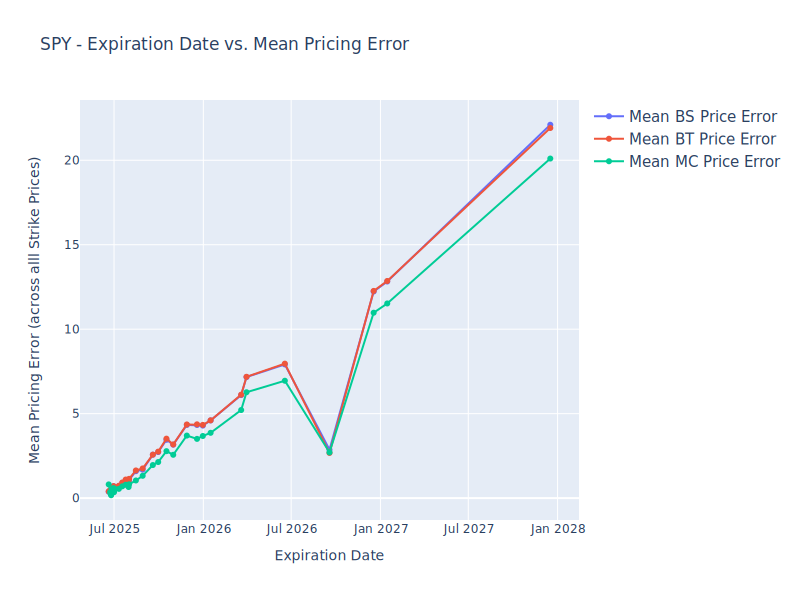

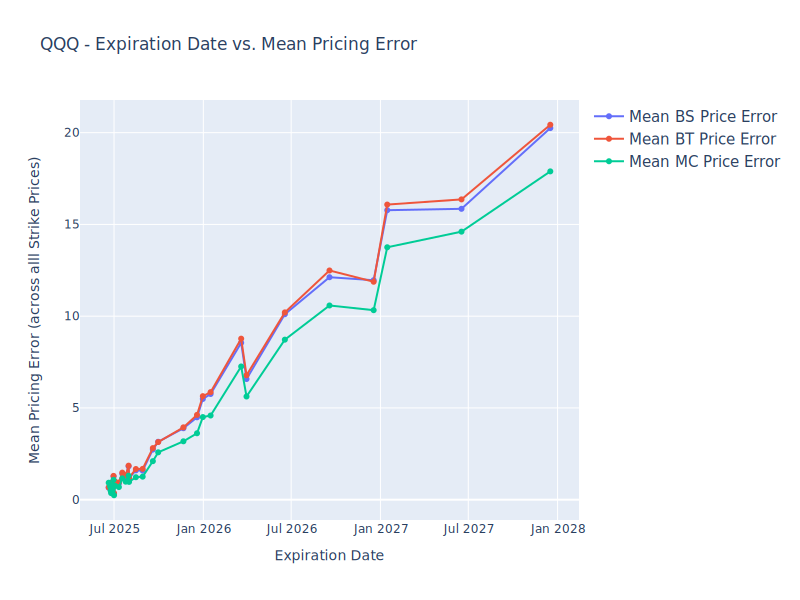

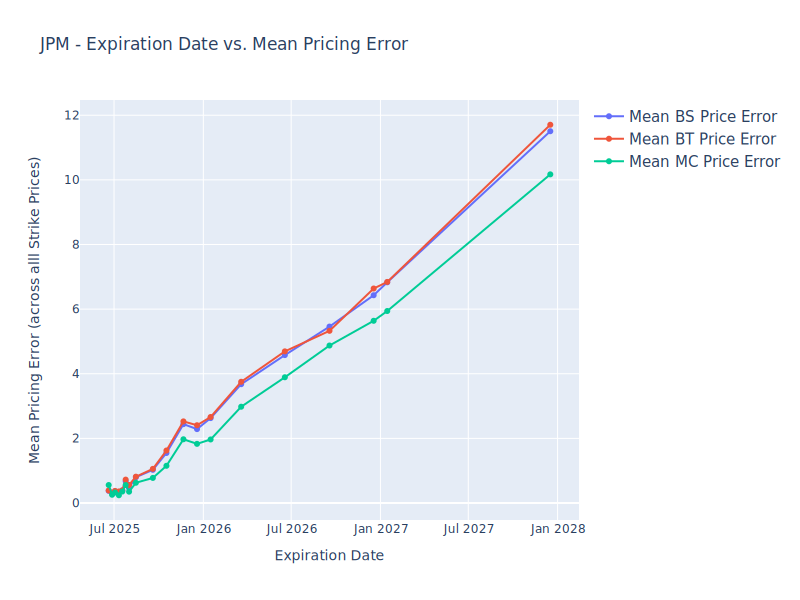

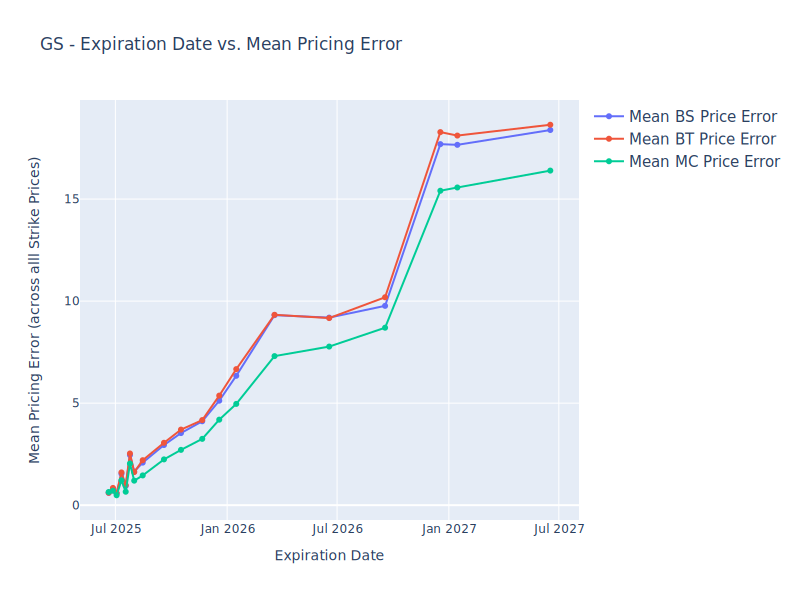

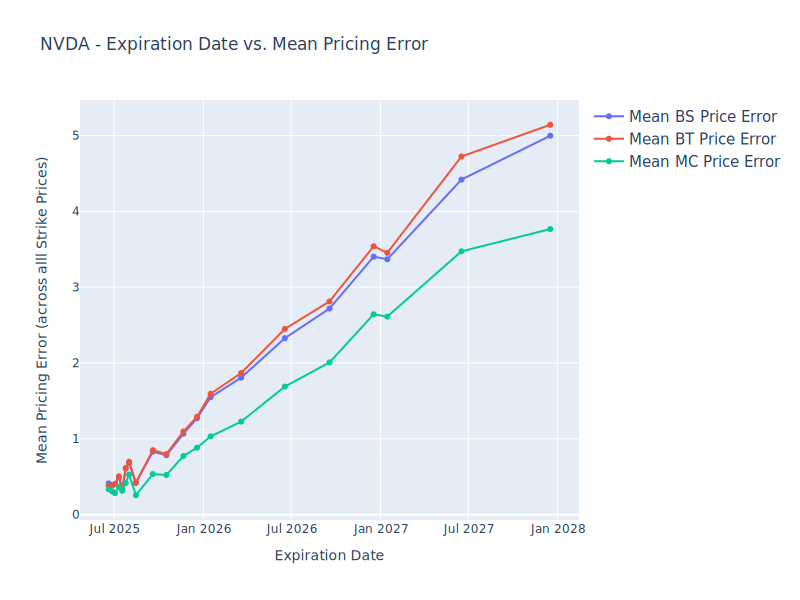

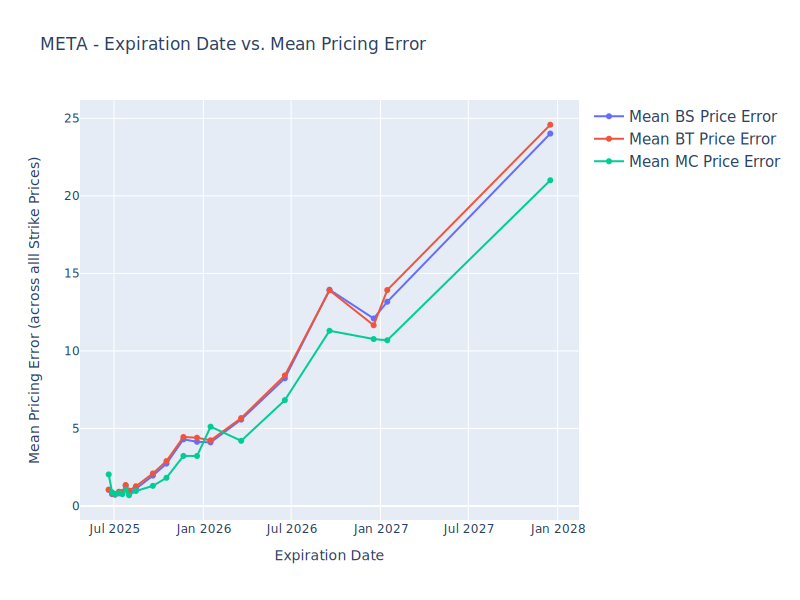

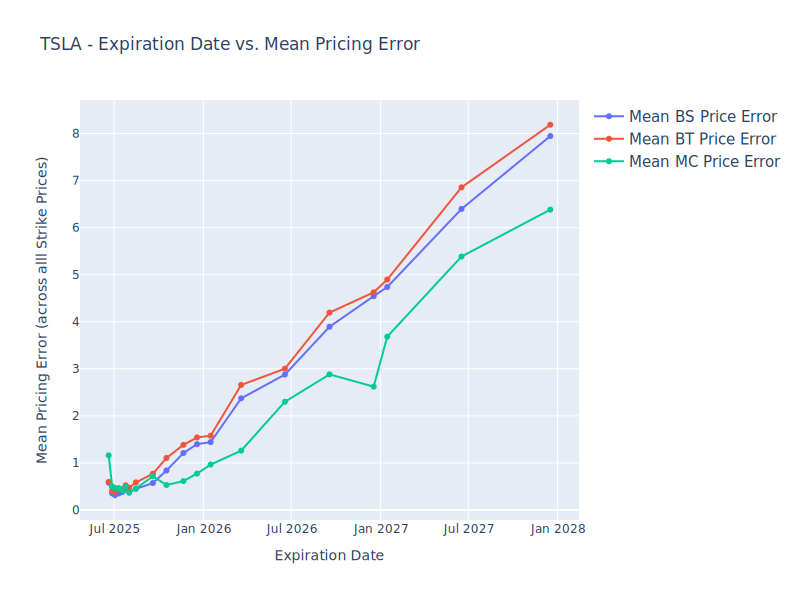

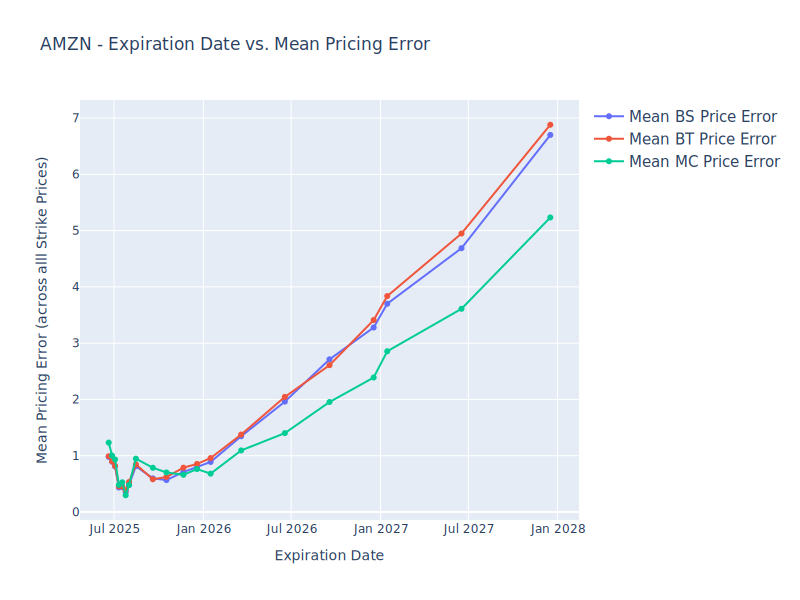

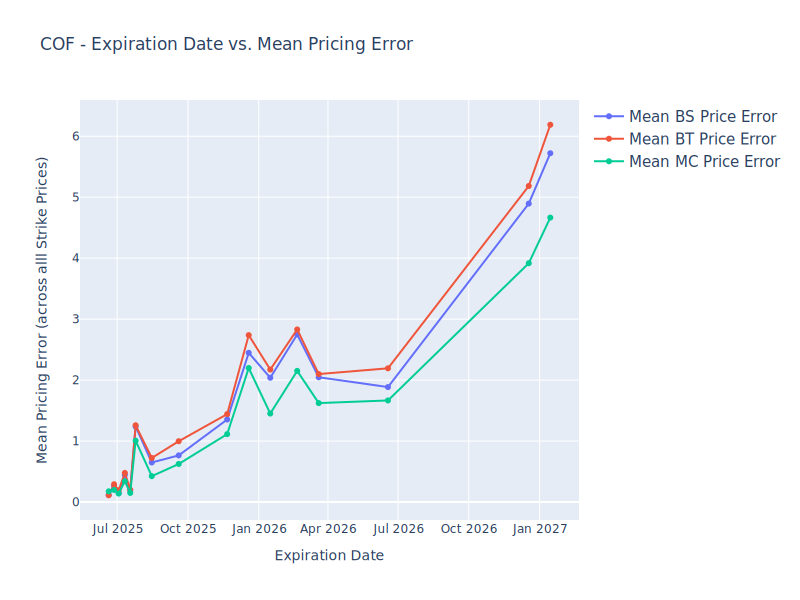

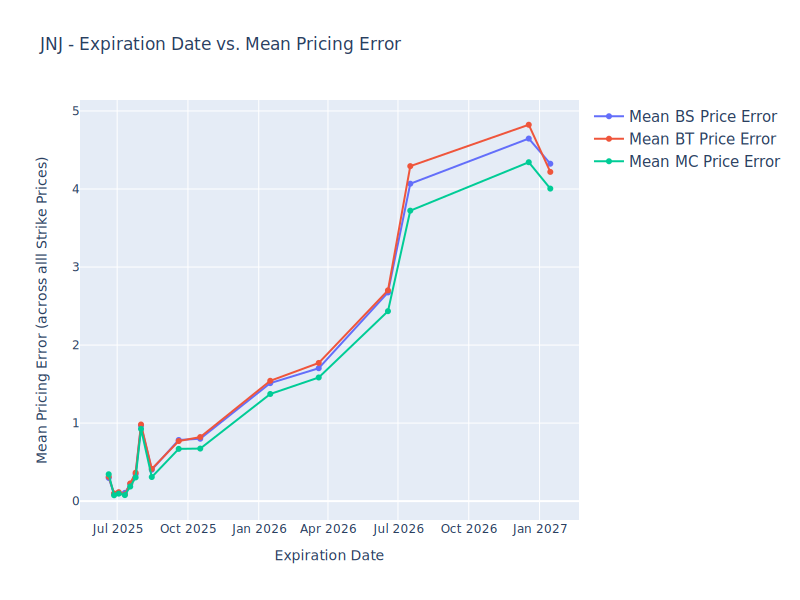

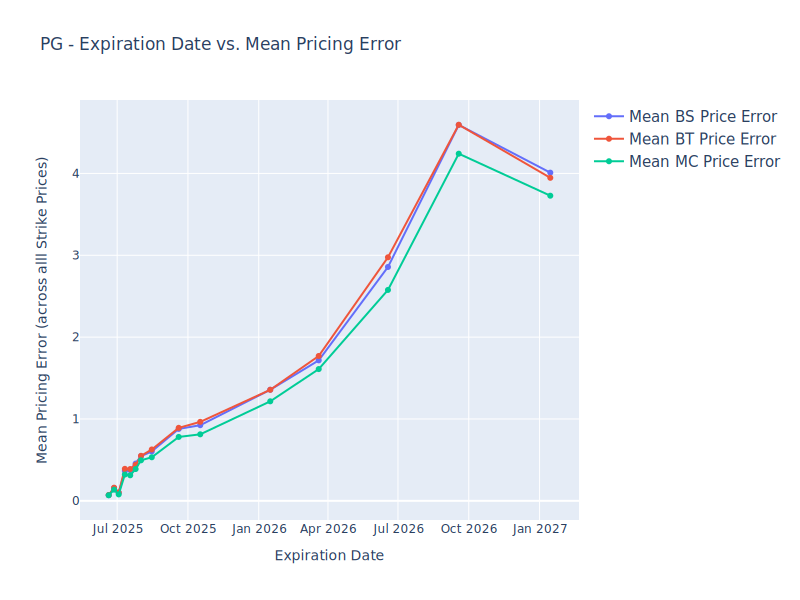

In [45]:
for stock_ticker in stock_tickers:
    plot_expiration_date_error(stock_ticker)

### Expiration Date Analysis

Overall, we can see that as the option's expiration date grows farther into the future, the option pricing calculations aren't as accurate. This is expected, since it is more difficult for the pricing method to capture the behavior of the underlying stock over a longer period of time.

We can also see that across all of the stocks, the 3 option pricing methods have the same trend of errors as the expiration date grows. However, the Monte Carlo method consistently has a lower error across all combinations of expirations dates and underlying stocks.